In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the data
df = pd.read_csv('Auronplay_videos.csv')

In [3]:
# Reemplazar 'Subtitle not available' por valores nulos en la columna 'transcript'
df['transcript'] = df['transcript'].replace('Subtitle not available', pd.NA)

In [4]:
# Check for missing values
print(df.isnull().sum())

video_id        0
title           0
description     0
publish_date    0
likes           0
views           0
comments        0
transcript      2
dtype: int64


In [5]:
# Check for duplicates
print(df.duplicated().sum())

2


In [6]:
# Convert 'publish_date' to datetime format
df['publish_date'] = pd.to_datetime(df['publish_date'])

In [7]:
# Extract features from 'publish_date'
df['year'] = df['publish_date'].dt.year
df['month'] = df['publish_date'].dt.month
df['day_of_week'] = df['publish_date'].dt.dayofweek
df['hour'] = df['publish_date'].dt.hour

In [8]:
# Create 'engagement rate'
df['engagement_rate'] = (df['likes'] + df['comments']) / df['views']

In [9]:
# Descriptive statistics
print(df.describe())

              likes         views       comments         year       month  \
count  3.510000e+02  3.510000e+02     351.000000   351.000000  351.000000   
mean   2.328499e+05  4.427076e+06    5029.860399  2021.586895    7.028490   
std    2.330183e+05  4.093930e+06   10328.090258     0.951840    3.651111   
min    4.113000e+04  5.647880e+05     461.000000  2019.000000    1.000000   
25%    1.117720e+05  2.061535e+06    1520.000000  2021.000000    3.000000   
50%    1.701750e+05  3.077356e+06    2103.000000  2022.000000    8.000000   
75%    2.386080e+05  5.011849e+06    4391.500000  2022.000000   10.000000   
max    2.466775e+06  3.080988e+07  135150.000000  2023.000000   12.000000   

       day_of_week        hour  engagement_rate  
count   351.000000  351.000000       351.000000  
mean      2.951567   17.720798         0.054778  
std       1.995836    3.975151         0.012048  
min       0.000000    0.000000         0.020489  
25%       1.000000   16.000000         0.047793  
50%   

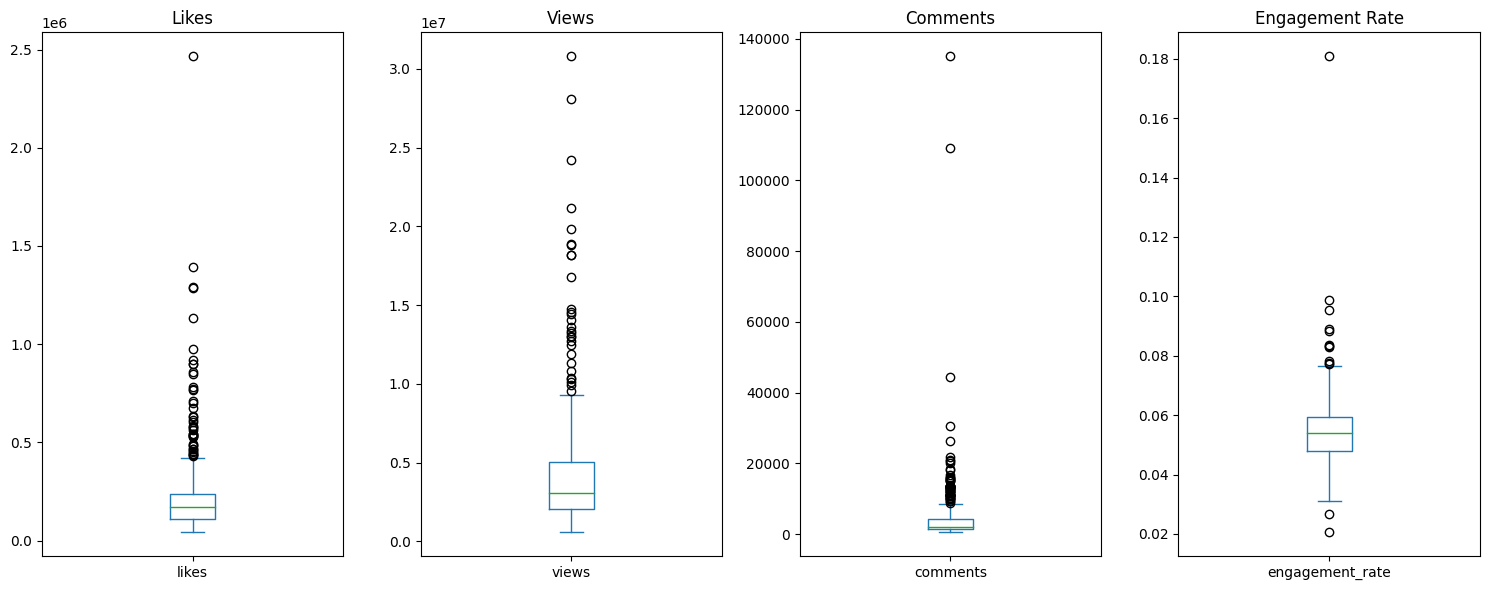

In [10]:
# Create a figure with subplots
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15, 6))

# Create box plots for each column and place them in the subplots
df['likes'].plot(kind='box', ax=axes[0])
df['views'].plot(kind='box', ax=axes[1])
df['comments'].plot(kind='box', ax=axes[2])
df['engagement_rate'].plot(kind='box', ax=axes[3])

# Set titles for subplots
axes[0].set_title('Likes')
axes[1].set_title('Views')
axes[2].set_title('Comments')
axes[3].set_title('Engagement Rate')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

array([[<AxesSubplot: title={'center': 'likes'}>,
        <AxesSubplot: title={'center': 'views'}>],
       [<AxesSubplot: title={'center': 'comments'}>,
        <AxesSubplot: title={'center': 'engagement_rate'}>]], dtype=object)

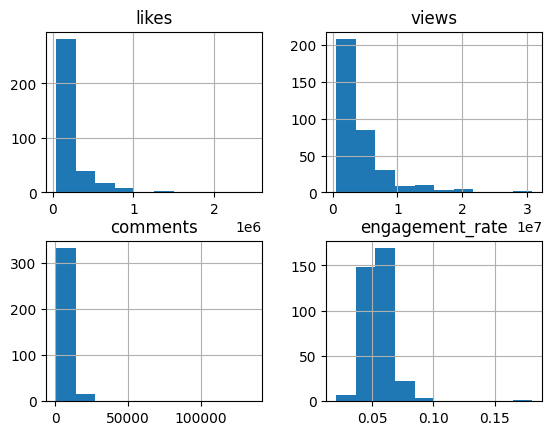

In [31]:
# Histograms
df[['likes', 'views', 'comments', 'engagement_rate']].hist()

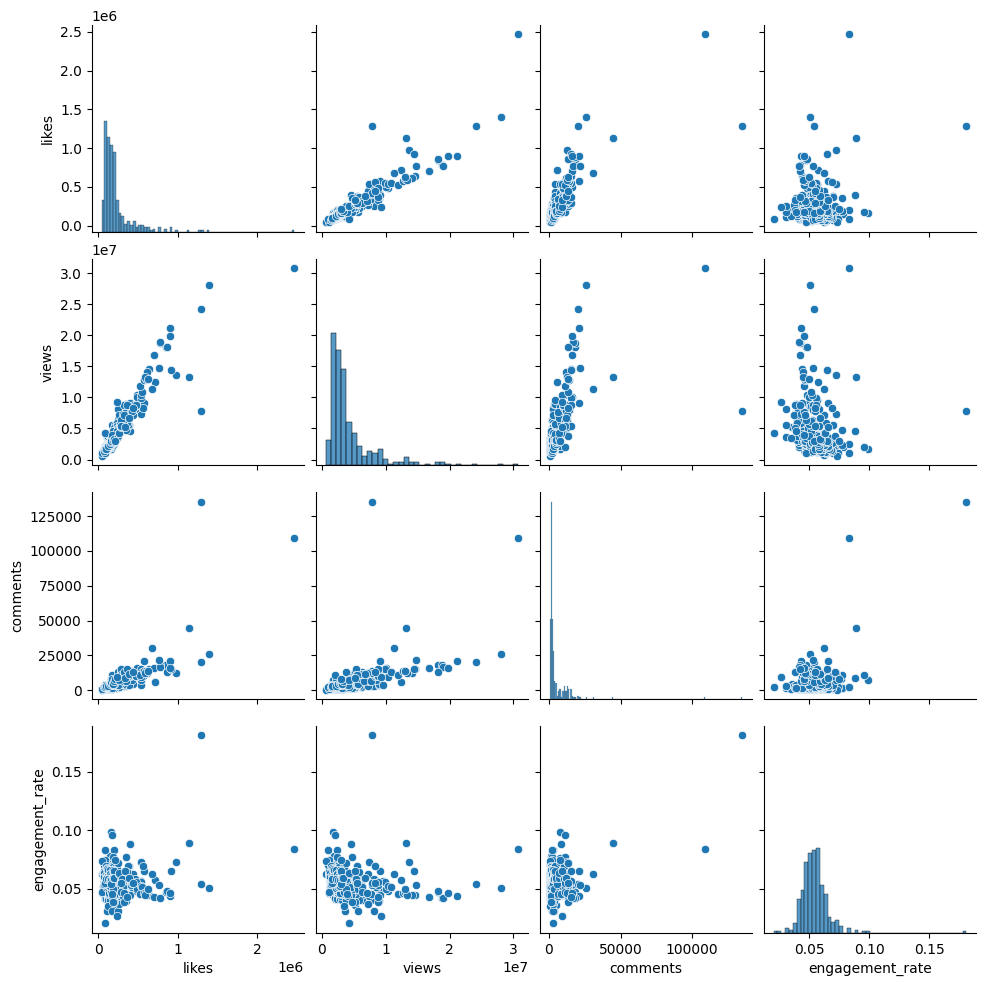

In [32]:
# Scatterplot matrix
sns.pairplot(df[['likes', 'views', 'comments', 'engagement_rate']])


<AxesSubplot: >

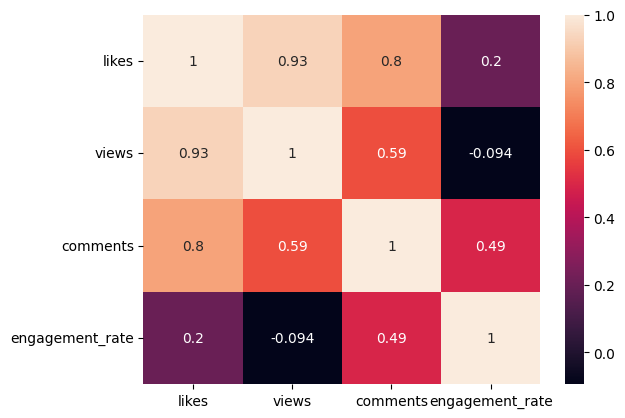

In [33]:
# Correlation matrix
corr_matrix = df[['likes', 'views', 'comments', 'engagement_rate']].corr()
sns.heatmap(corr_matrix, annot=True)

<AxesSubplot: xlabel='publish_date'>

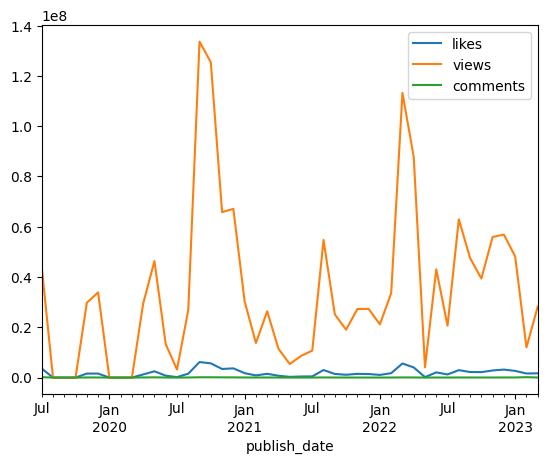

In [34]:
# Time series analysis
df.set_index('publish_date').resample('M')[['likes', 'views', 'comments']].sum().plot()

<AxesSubplot: xlabel='day_of_week'>

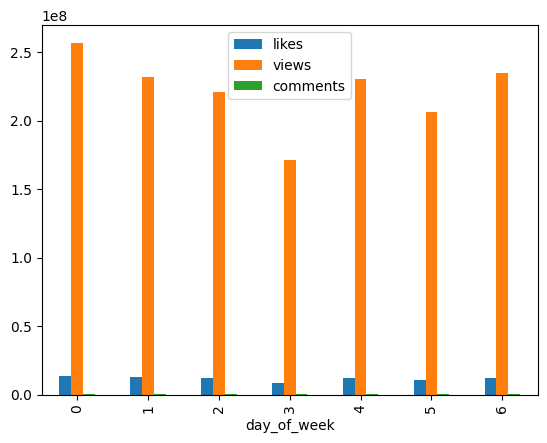

In [35]:
# Time series analysis by day of week
df.groupby('day_of_week')[['likes', 'views', 'comments']].sum().plot(kind='bar')

<AxesSubplot: xlabel='hour'>

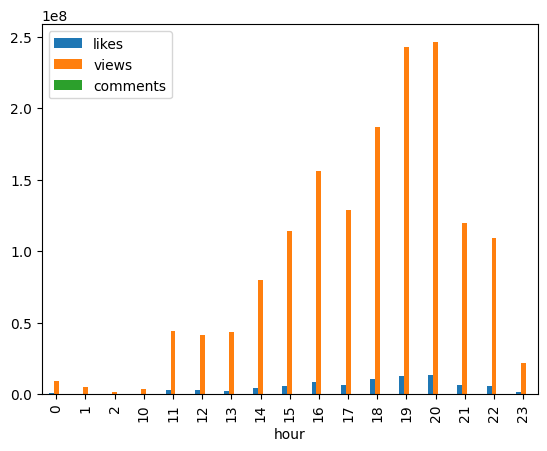

In [36]:
# Time series analysis by hour
df.groupby('hour')[['likes', 'views', 'comments']].sum().plot(kind='bar')

In [37]:
# Most popular videos
print(df[df['views'] == df['views'].max()]['title'])

350    mi primer ASMR espero k os guste - AuronPlay
Name: title, dtype: object


In [38]:
import spacy
import emoji
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from spacy.lang.es.stop_words import STOP_WORDS
from spellchecker import SpellChecker
import deepl
from langdetect import detect

In [39]:
auth_key = "e43fc475-8566-0cb8-6db8-0ab3b5ebd77f"
translator = deepl.Translator(auth_key)

In [40]:
# Load Spanish tokenizer, POS tagger, parser, NER and word vectors
nlp = spacy.load('es_core_news_sm')

In [41]:
def translate_with_deepl(text, target_lang='ES'):
    detected_lang = detect(text)
    if detected_lang != 'es':
        try:
            return translator.translate_text(text, target_lang=target_lang).text
        except Exception as e:
            print(f"DeepL translation failed with error: {str(e)}")
            return text
    return text

def preprocess(text):
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Replace emojis with text
    text = emoji.demojize(text, delimiters=("", ""))

    # Lowercase the text
    text = text.lower()

    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    # Detect the language
    if not text:
        return ''

    lang = detect(text)

    # Translate the text to Spanish if the language is not Spanish
    if lang != 'es':
        text = translate_with_deepl(text)

    # Tokenize, remove stop words, and lemmatize using SpaCy's Spanish model
    doc = nlp(text)
    result = []
    for token in doc:
        if token.text in nlp.Defaults.stop_words or token.is_stop:
            continue
        lemma = token.lemma_
        if lemma not in result:  # Remove duplicates
            result.append(lemma)

    return result


In [42]:
# Apply preprocessing to each column & Check if values in columns are of string or bytes-like type
df['title_preprocessed'] = df['title'].apply(lambda x: preprocess(str(x)) if isinstance(x, (str, bytes)) else '')
df['description_preprocessed'] = df['description'].apply(lambda x: preprocess(str(x)) if isinstance(x, (str, bytes)) else '')
df['transcript_preprocessed'] = df['transcript'].apply(lambda x: preprocess(str(x)) if isinstance(x, (str, bytes)) else '')

In [43]:
# Apply preprocessing to each column
#df['title_preprocessed'] = df['title'].apply(preprocess)
#df['description_preprocessed'] = df['description'].apply(preprocess)
#df['transcript_preprocessed'] = df['transcript'].apply(preprocess)

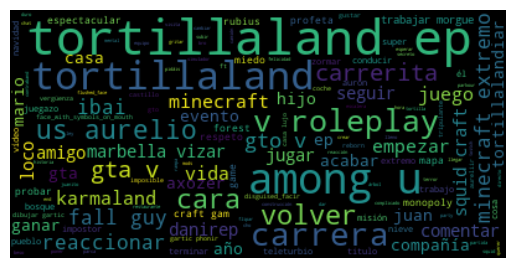

In [44]:
# Word frequency analysis
title_words = ' '.join([' '.join(doc) for doc in df['title_preprocessed']])
wordcloud = WordCloud().generate(title_words)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig("title_preprocessed.png")
plt.show()

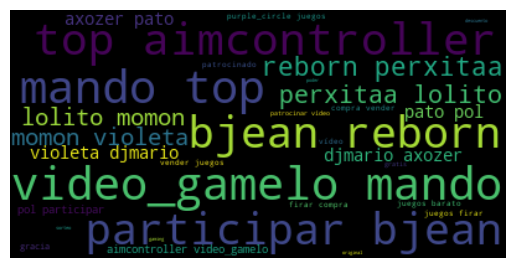

In [45]:
description_words = ' '.join([' '.join(doc) for doc in df['description_preprocessed']])
wordcloud = WordCloud().generate(description_words)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig("description_preprocessed.png")
plt.show()

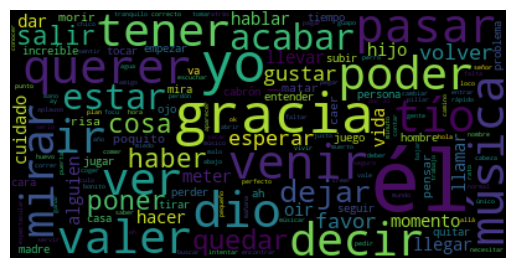

In [46]:
transcript_words = ' '.join([' '.join(doc) for doc in df['transcript_preprocessed']])
wordcloud = WordCloud().generate(transcript_words)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig("transcript_preprocessed.png")
plt.show()

In [47]:
import nltk

In [48]:
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize

# Concatenate all preprocessed title, description, and transcript texts
all_words = ' '.join([' '.join(doc) for doc in df['title_preprocessed']]) + \
             ' '.join([' '.join(doc) for doc in df['description_preprocessed']]) + \
             ' '.join([' '.join(doc) for doc in df['transcript_preprocessed']])

# Tokenize
all_tokens = word_tokenize(all_words)

# Create frequency distribution
fdist = FreqDist(all_tokens)

# Print the 10 most common words
print(fdist.most_common(10))


[('él', 3650), ('yo', 932), ('dar', 547), ('ver', 485), ('poner', 483), ('decir', 462), ('hacer', 444), ('dejar', 430), ('ir', 405), ('pasar', 394)]


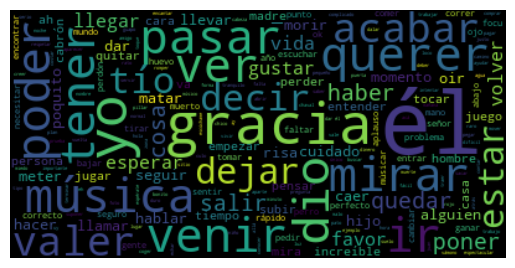

In [49]:
# All words
wordcloud = WordCloud().generate(all_words)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig("all_words.png")
plt.show()

In [50]:
# Load preprocessed data
df.to_csv('preprocessed_data.csv', index=False)